In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import collections
from sklearn import model_selection
import math
import os

import sys
sys.path.append('../')

from losses import triplet_hard_loss, triplet_semihard_loss
from model import create_model
from generator import create_dataset, preprocess_input
from optimizer import get_optimizer
from util import read_data
from config import config

tf.config.set_visible_devices([], 'GPU')

In [2]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    return tf.image.decode_jpeg(image, channels=3)
    

data = read_data('../../input/landmark-retrieval-2020/')
data

,landmark_id,path
0,1,../../input/landmark-retrieval-2020/train/1/7/...
1,7,../../input/landmark-retrieval-2020/train/2/5/...
2,9,../../input/landmark-retrieval-2020/train/0/1/...
3,11,../../input/landmark-retrieval-2020/train/1/a/...
4,12,../../input/landmark-retrieval-2020/train/0/a/...
...,...,...
81308,203083,../../input/landmark-retrieval-2020/train/1/d/...
81309,203085,../../input/landmark-retrieval-2020/train/0/9/...
81310,203087,../../input/landmark-retrieval-2020/train/1/4/...
81311,203091,../../input/landmark-retrieval-2020/train/8/e/...


In [88]:
model1 = create_model(
    input_shape=config['input_size'],
    n_classes=config['n_classes'],
    dense_units=config['dense_units'],
    dropout_rate=config['dropout_rate'],
    regularization_factor=config['regularization_factor'],
    loss=config['loss']['type'],
    scale=config['loss']['scale'],
    margin=config['loss']['margin'],
)
model1.load_weights('../../output/weights/model.h5')
model1 = tf.keras.Model(
    inputs=model1.get_layer('input/image').input,
    outputs=model1.get_layer('head/dense').output
)

distance between anchor and positive = 0.8442861
distance between anchor and negative = 1.2264032


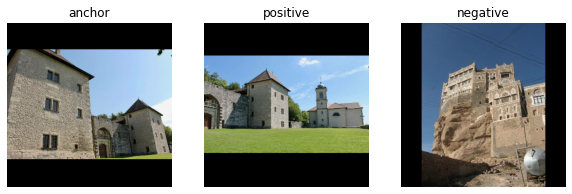

In [89]:
im1 = read_image(data.iloc[781].path.split(',')[0])
im2 = read_image(data.iloc[781].path.split(',')[1])
im3 = read_image(data.iloc[4003].path.split(',')[1])

im1 = preprocess_input(
        im1, config['input_size'][:2], config['pad_on_resize'])
im2 = preprocess_input(
        im2, config['input_size'][:2], config['pad_on_resize'])
im3 = preprocess_input(
        im3, config['input_size'][:2], config['pad_on_resize'])

emb1 = tf.math.l2_normalize(model1(im1[tf.newaxis]), axis=1)[0]
emb2 = tf.math.l2_normalize(model1(im2[tf.newaxis]), axis=1)[0]
emb3 = tf.math.l2_normalize(model1(im3[tf.newaxis]), axis=1)[0]


fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for lab, im, ax in zip(['anchor', 'positive', 'negative'], [im1, im2, im3], axes.reshape(-1)):
    ax.imshow(im);
    ax.set_title(lab)
    ax.axis('off')
    
print('distance between anchor and positive =', np.linalg.norm(emb1-emb2))
print('distance between anchor and negative =', np.linalg.norm(emb1-emb3))

In [90]:
served_model = tf.saved_model.load('../../tmp/model/')
model2 = served_model.signatures["serving_default"]

distance between anchor and positive = 0.7114056
distance between anchor and negative = 1.27473


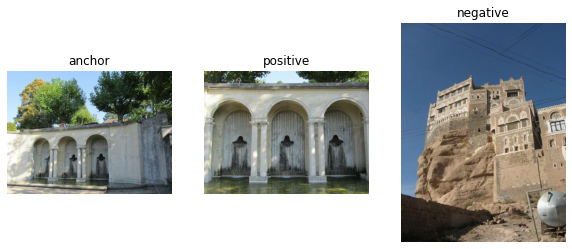

In [105]:
im1 = read_image(data.iloc[4].path.split(',')[0])
im2 = read_image(data.iloc[4].path.split(',')[3])
im3 = read_image(data.iloc[4003].path.split(',')[1])

emb1 = model2(input_image=im1)['global_descriptor']
emb2 = model2(input_image=im2)['global_descriptor']
emb3 = model2(input_image=im3)['global_descriptor']

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for lab, im, ax in zip(['anchor', 'positive', 'negative'], [im1, im2, im3], axes.reshape(-1)):
    ax.imshow(im);
    ax.set_title(lab)
    ax.axis('off')
    
print('distance between anchor and positive =', np.linalg.norm(emb1-emb2))
print('distance between anchor and negative =', np.linalg.norm(emb1-emb3))

In [68]:
emb1

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-0.03497005, -0.06947808, -0.0204732 , ..., -0.06273727,
       -0.03486067,  0.01984366], dtype=float32)>

In [17]:
print(emb1)

tf.Tensor(
[-0.04063879 -0.08074172 -0.02377852 ... -0.07290022 -0.04048088
  0.02305772], shape=(2048,), dtype=float32)


In [18]:
print(emb2)

tf.Tensor(
[-0.03621838 -0.07196076 -0.02119938 ... -0.06496775 -0.03609614
  0.02054843], shape=(2048,), dtype=float32)


In [7]:
emb = np.random.uniform(0, 1, size=(256, 256, 3))

In [8]:
out = model(emb[np.newaxis])

In [10]:
tf.math.l2_normalize(out, axis=1)

<tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
array([[-0.01294412, -0.02562219, -0.00740279, ..., -0.02269634,
        -0.01281309,  0.00738812]], dtype=float32)>

In [11]:
tf.math.l2_normalize(out[0])

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-0.01294412, -0.02562219, -0.00740279, ..., -0.02269634,
       -0.01281309,  0.00738812], dtype=float32)>